In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.mixture import GaussianMixture
!pip install fuzzy-c-means
from fcmeans import FCM
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

ANUGYA SAXENA :MOVIE RECOMMENDER ATTEMPT

In [97]:
data=pd.read_csv('/content/movies1.csv')

In [98]:
unique_genres = data['genres'].nunique()
unique_titles = data['title'].nunique()

print(f"Number of unique entities in the 'genres' column: {unique_genres}")
print(f"Number of unique entities in the 'title' column: {unique_titles}")

Number of unique entities in the 'genres' column: 550
Number of unique entities in the 'title' column: 5888


In [99]:
data['genre_list'] = data['genres'].str.split(', ')


mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(data['genre_list'])
genre_encoded_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

data = pd.concat([data, genre_encoded_df], axis=1)

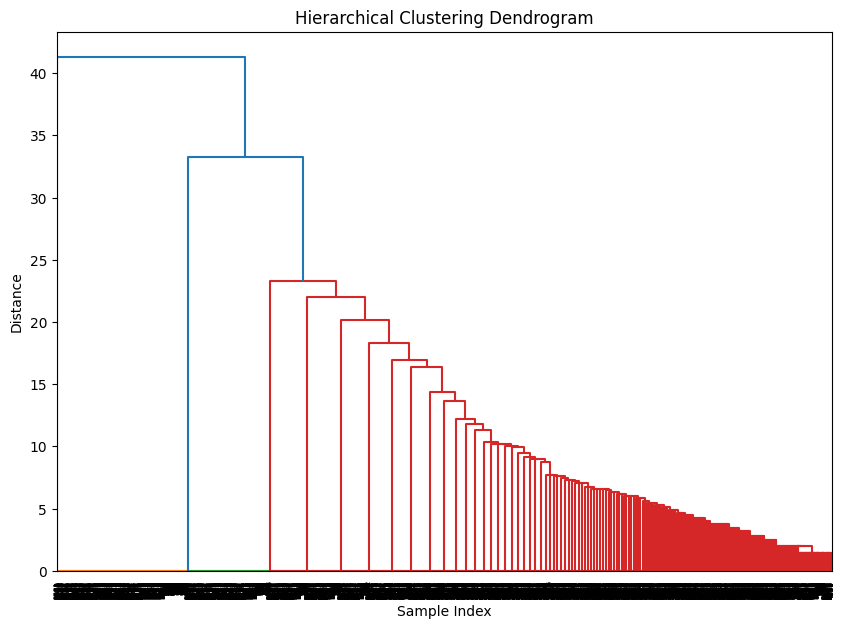

In [100]:
#HIERARCHICAL CLUSTERING AND VISUALISE
import sys
sys.setrecursionlimit(10000)

X =genre_encoded_df.values

Z = linkage(X, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(Z, labels=data.index.values)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

In [ ]:
#FUZZY C MEANS CLUSTRING

X =genre_encoded_df.values

n_clusters = 3
fcm = FCM(n_clusters=n_clusters)
fcm.fit(X)

centers = fcm.centers
membership = fcm.u  # probabilities

clusters = np.argmax(membership, axis=1)
data['Cluster'] = clusters  # cluster assignments to the DataFrame

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
for cluster in range(n_clusters):
    plt.scatter(X_reduced[clusters == cluster, 0], X_reduced[clusters == cluster, 1], label=f'Cluster {cluster}')

plt.scatter(pca.transform(centers)[:, 0], pca.transform(centers)[:, 1],
            s=200, c='red', marker='X', label='Centers')
plt.title("Fuzzy C-Means Clustering on movies1.csv")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.legend()
plt.show()

data.to_csv("movies1_fuzzy_c_means_results.csv", index=False)


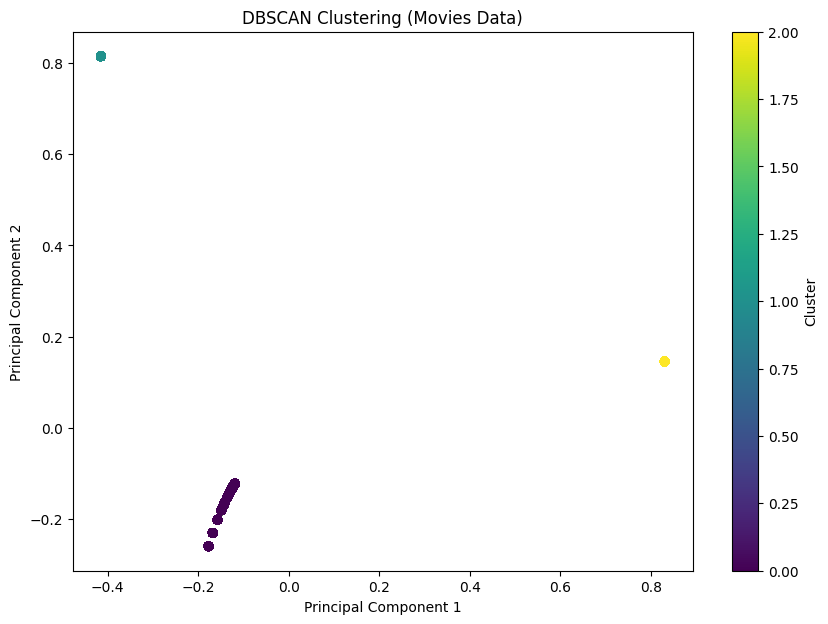

In [117]:
db = DBSCAN(eps=0.5, min_samples=15)

pca = PCA(n_components=2)
X_reduced_original = pca.fit_transform(data[mlb.classes_])  # Caution:use original data's genre columns

cluster_labels = db.fit_predict(X_reduced_original)  # Get cluster labels

clustered_data = pd.DataFrame(X_reduced_original, columns=['PCA1', 'PCA2'])
clustered_data['Cluster'] = cluster_labels
clustered_data['title'] = data['title'] #add title for identification

# Now you can visualize the clustered data:
plt.figure(figsize=(10, 7))
plt.scatter(clustered_data['PCA1'], clustered_data['PCA2'], c=clustered_data['Cluster'], cmap='viridis', marker='o')
plt.title('DBSCAN Clustering (Movies Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

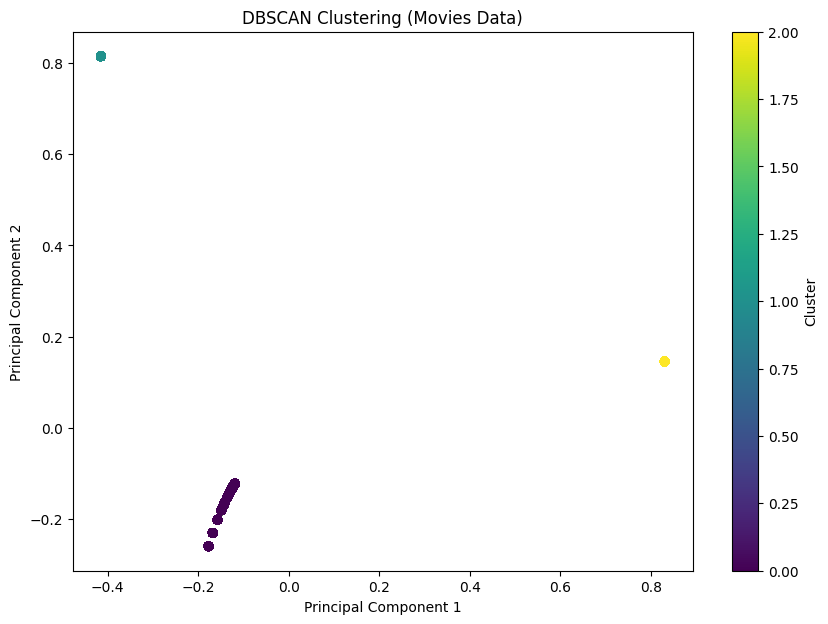

In [112]:
db = DBSCAN(eps=0.5, min_samples=15)
pca = PCA(n_components=2)
X_reduced_original = pca.fit_transform(data[mlb.classes_])  # Use original data

data['Cluster'] = db.fit_predict(X_reduced_original)  # Assign to original data


plt.figure(figsize=(10,7))
plt.scatter(X_reduced_original[:, 0], X_reduced_original[:, 1], c=data['Cluster'], cmap='viridis', marker='o')
plt.title('DBSCAN Clustering (Movies Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
from scipy.cluster.hierarchy import fcluster
max_d = 8 # CUT DENDOGRAM
clusters = fcluster(Z, max_d, criterion='distance')

data['Cluster'] = clusters
print(data[['Cluster']].head())


In [ ]:
print(data['Cluster'].value_counts())

for cluster_num in sorted(data['Cluster'].unique()):
    print(f"\nCluster {cluster_num}:")
    print(data[data['Cluster'] == cluster_num].head())  # Display first few rows in the cluster


In [ ]:
#PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1], c=data['Cluster'], cmap='viridis')
plt.title("Hierarchical Clustering (PCA Reduced Dimensions)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


In [ ]:
#T-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_components = tsne.fit_transform(X)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=data['Cluster'], cmap='viridis')
plt.title("Hierarchical Clustering (t-SNE Reduced Dimensions)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


In [42]:
#how good cluster
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X, data['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.4810906476411663


In [114]:
import re
from scipy.spatial.distance import cdist

def recommend_movie(input_movie_title):
    """Recommends movies based on hierarchical clustering and PCA."""

    input_movie_title = re.sub(r'\(\d{4}\)', '', input_movie_title).strip()  # Remove year and extra spaces

    #  genre of the input movie (without year)
    input_movie = data[data['title'].str.contains(input_movie_title, flags=re.IGNORECASE, regex=True)]

    if input_movie.empty:
        print("Movie not found in the dataset.")
        return []

    input_genre_encoded = input_movie[mlb.classes_].values[0]
    input_genre_encoded_df = pd.DataFrame([input_genre_encoded], columns=mlb.classes_)

    pca = PCA(n_components=2)
    pca.fit(genre_encoded_df)#debug

    input_genre_pca = pca.transform(input_genre_encoded_df)[0]

    distances = cdist([input_genre_pca], pca_components, metric='euclidean')


    num_recommendations = 10
    closest_indices = np.argsort(distances[0])[1:num_recommendations + 1]  # xclude input movie

    recommended_movie_titles = data.iloc[closest_indices]['title'].values

    return recommended_movie_titles


In [115]:
input_movie_title = input("Enter a movie title: ")

recommended_movies = recommend_movie(input_movie_title)

if recommended_movies.size > 0:
    print("\nMovies recommended for you:")
    for movie_title in recommended_movies:
        print(movie_title)
else:
    print("\nNo recommendations found for this movie.")

Enter a movie title: jumanji

Movies recommended for you:
Boomerang (1992)
Bringing Up Baby (1938)
Clueless (1995)
His Girl Friday (1940)
Threesome (1994)
Barcelona (1994)
My Man Godfrey (1936)
Nina Takes a Lover (1994)
Only You (1994)
Perez Family, The (1995)
